# Preliminary image processing task
* CUDA, cuDNN, and cuBLAS libraries support for GPU acceleration - Yet to be done. 
* Pre-trained Convolutional Neural Networks (CNNs) such as VGG, MobileNet, DenseNet, ResNet, InceptionV4, and CoCa
* Dropout layers with a dropout rate of 0.2 to prevent overfitting
* Reduce batch sizes from 64 or 32 if memory limitations
* train each model for 30 epochs initially, but adjust the number of epochs based on the observed accuracy during training.


Imports

In [1]:
import torch
import timm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
import os
import random
import shutil
from torchvision import datasets
import numpy as np
from pytorch_lightning.loggers import CSVLogger
import datetime


c:\Users\hifia\anaconda3\envs\DementiaGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hifia\anaconda3\envs\DementiaGPU\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [28]:
avail_pretrained_models = timm.list_models(pretrained=True)
print(avail_pretrained_models)

['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

Check GPU

In [30]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


Loading a few pre-trained models (Re run this once the epochs are done for the first one, and comment the first one out so that we don't lose our evaluation results)

In [31]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

densenet = timm.create_model('densenet121', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

Device: cuda


In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")
densenet = torch.load('densenet121.pth').to(device)

Device: cuda


Check Path Accuracy

In [ ]:
print(os.listdir('Alzheimer_s Dataset_binary\\src')) # Preliminary Image Processing\Alzheimer_s Dataset_binary\src
print(os.listdir('Alzheimer_s Dataset_binary\\train'))
print(os.listdir('Alzheimer_s Dataset_binary\\test'))
print(os.listdir('Alzheimer_s Dataset_binary\\val'))

Train Test Validation Split

In [ ]:
# Define the source folder containing subfolders for each class
source_folder = 'Alzheimer_s Dataset_binary\\src'
train_folder = 'Alzheimer_s Dataset_binary\\train'
test_folder = 'Alzheimer_s Dataset_binary\\test'
val_folder = 'Alzheimer_s Dataset_binary\\val'

# Define the ratios for train, test, and validation sets
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Create destination folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# List subfolders (classes) in the source folder
classes = os.listdir(source_folder)

# Loop through each class
for class_name in classes:
    class_source_folder = os.path.join(source_folder, class_name)
    class_train_folder = os.path.join(train_folder, class_name)
    class_test_folder = os.path.join(test_folder, class_name)
    class_val_folder = os.path.join(val_folder, class_name)

    # List image files in the class source folder
    image_files = os.listdir(class_source_folder)
    random.shuffle(image_files)

    # Calculate the number of images for each set based on the defined ratios
    total_images = len(image_files)
    train_split = int(total_images * train_ratio)
    test_split = int(total_images * test_ratio)

    # Copy image files to their respective folders for train, test, and validation
    for i, image_file in enumerate(image_files):
        source_path = os.path.join(class_source_folder, image_file)
        if i < train_split:
            destination_folder = class_train_folder
        elif i < train_split + test_split:
            destination_folder = class_test_folder
        else:
            destination_folder = class_val_folder

        destination_path = os.path.join(destination_folder, image_file)
        shutil.copyfile(source_path, destination_path)


Batch Creation

In [32]:
transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training dataset
train_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/temp_train', transform=transform)
test_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/test', transform=transform)

In [ ]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
train_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/train', transform=transform)
test_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/test', transform=transform)
val_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/val', transform=transform)

batch_size = 26  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(len(train_loader))
print(len(test_loader))
print(len(val_loader))
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

CSV Logger setup

In [4]:
import csv
import os
class CSVLogger:
    def __init__(self, filename, fieldnames):
        self.filename = filename
        self.fieldnames = fieldnames

        # Create and initialize the CSV file
        if not os.path.isfile(self.filename):
            with open(self.filename, 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
                writer.writeheader()
        else:
            with open(self.filename, 'a', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
                writer.writerow({})

    def log(self, data):
        # Append data to the CSV file
        with open(self.filename, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writerow(data)


Unified setup code

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

densenet = timm.create_model('densenet121', pretrained=False, num_classes=2, drop_rate=0.25).to(device)

transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training dataset
train_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/temp_train', transform=transform)
test_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/test', transform=transform)

# data_loaders = [train_loader, test_loader, val_loader]
k = 5
batch_size = 26  # Adjust as needed
results = []
from sklearn.model_selection import KFold
kf = KFold(n_splits=k, shuffle=True, random_state=0)

Device: cuda


Densenet

In [6]:
losslogger = CSVLogger("lossLogDensenet.csv", fieldnames=["datetime", "batch", "k", "epoch", "train_loss", "val_loss", "val_acc"])
acclogger = CSVLogger("accLogDensenet.csv", fieldnames=["datetime", "average_accuracy"])

test_loader = DataLoader(test_dataset, batch_size=batch_size)
for train_idx, val_idx in kf.split(train_dataset):
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)

    loss_value = torch.nn.CrossEntropyLoss()

    densenet_opt = optim.SGD(densenet.parameters(), lr=0.001, momentum=0.9)
    # Try with adam

    # Training loop
    num_epochs = 30
    early_stopping = False  
    best_loss = float('inf') 
    patience = 5 

    for epoch in range(num_epochs):
        densenet.train()  
        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            densenet_opt.zero_grad()
            outputs = densenet(inputs)
            loss = loss_value(outputs, labels)
            loss.backward()
            densenet_opt.step()
        
        # Validation
        total = 0
        correct = 0
        densenet.eval()  
        val_loss = 0.0
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = densenet(val_inputs)
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            val_loss += loss_value(val_outputs, val_labels).item()
        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        
        print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")
        losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "k": k, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_acc": val_acc}
        losslogger.log(losslog_data)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0  
        else:
            patience_counter += 1  
            
            # If validation loss hasn't improved for 'patience' epochs, stop early
            if patience_counter >= patience:
                print("Early stopping triggered")
                early_stopping = True
                break
        
        if early_stopping:
            break

    # -----------------------------------------

    correct = 0
    total = 0
    densenet.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = densenet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    results.append(accuracy)
    print("Done \n\n")

avg = np.mean(results)
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": avg}
acclogger.log(acclog_data)
print(f"Average accuracy: {avg:.2f}%")
print(results)

Completed epoch 1 with loss 0.49352848529815674, validation loss 0.6043734219742984
Completed epoch 2 with loss 1.1157633066177368, validation loss 0.5515590764400435
Completed epoch 3 with loss 0.4692501425743103, validation loss 0.5254732999132901
Completed epoch 4 with loss 0.2421223223209381, validation loss 0.4935418687215665
Completed epoch 5 with loss 0.1100921481847763, validation loss 0.441769704199964
Completed epoch 6 with loss 0.7144973278045654, validation loss 0.3481374135831507
Completed epoch 7 with loss 1.1177823543548584, validation loss 1.756143155704283
Completed epoch 8 with loss 0.7687786221504211, validation loss 0.6419141999440177
Completed epoch 9 with loss 1.053990125656128, validation loss 1.5207652161631713
Completed epoch 10 with loss 0.01753559336066246, validation loss 0.4493750196359143
Completed epoch 11 with loss 0.004535051062703133, validation loss 0.332630767697105
Completed epoch 12 with loss 0.834233283996582, validation loss 0.23954605492876657
C

KeyboardInterrupt: 

Result: Training loss fluctuating, validation loss somewhat uniform, there is overfitting

In [23]:
print(results)

[97.7124183006536, 98.69281045751634, 98.91067538126362, 99.34640522875817, 99.56427015250544]


datetime      2023-10-16 16:41:00.636817
batch                               26.0
k                                    5.0
epoch                                1.0
train_loss                      0.493528
val_loss                        0.604373
val_acc                        67.435159
Name: 75, dtype: object


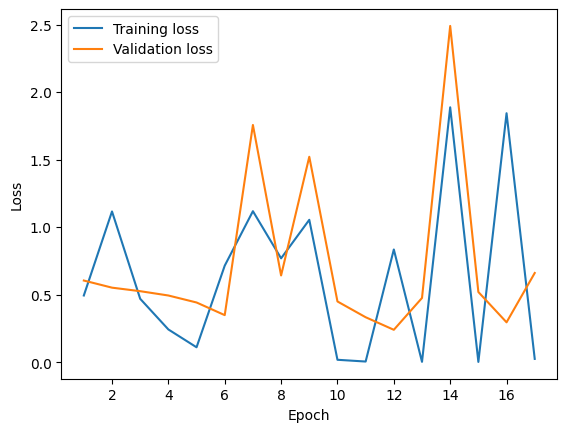

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

loss_df = pd.read_csv("lossLogDensenet.csv")
print(loss_df.iloc[75, :])
train_loss = loss_df["train_loss"][75:-3]
epochs = loss_df["epoch"][75:-3]
val_loss = loss_df["val_loss"][75:-3]
plt.plot(epochs, train_loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()